### Стоимость жилья в объявлении

In [35]:
import numpy
import pandas
import sklearn.ensemble

from sklearn.metrics import mean_absolute_error as MAE
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

Добавим в базовую попытку поле с датой:

In [36]:
def date_to_num(date_str):
    yy, mm, dd = map(int, date_str.split('-'))
    return 365*(yy-2011)+30*mm+dd

In [37]:
train = pandas.read_csv('Train.csv')
test = pandas.read_csv('Test.csv')

train['mydate']=train['date'].apply(date_to_num)
test['mydate']=test['date'].apply(date_to_num)

train.head(3)

,id,date,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,...,kw6,kw7,kw8,kw9,kw10,kw11,kw12,kw13,price,mydate
0,0,2011-01-01,531,NaN,12,35,1,1,25.0,NaN,...,0,0,0,0,0,0,0,0,3721000,31
1,1,2011-01-01,385,2.0,15,46,1,2,15.0,1.0,...,0,0,0,0,0,0,0,0,7431000,31
2,2,2011-01-01,51,0.0,1,53,3,0,30.0,0.0,...,0,0,0,0,0,0,0,0,3081000,31


In [38]:
train = train.replace(numpy.nan, -1)
test = test.replace(numpy.nan, -1)

COLUMNS = ['mydate','street_id', 'build_tech', 'floor', 
           'area', 'rooms', 'balcon', 'metro_dist', 
           'g_lift', 'n_photos', 'kw1', 'kw2', 'kw3', 'kw4', 
           'kw5', 'kw6', 'kw7', 'kw8', 'kw9', 'kw10', 'kw11', 'kw12', 'kw13']

y = train['price'].values
X = train[COLUMNS].values
Xt = test[COLUMNS].values

mdl = sklearn.ensemble.RandomForestRegressor(n_estimators=100)
mdl.fit(X, y)

preds = mdl.predict(Xt)

test['price'] = preds

test[['id', 'price']].to_csv('sub4.csv', index=False)

Будем использовать перекрёстную проверку (cross-validation), 
в качестве метрики возьмём MAE.

In [39]:
print(cross_val_score(mdl, X, y, cv=5, scoring='neg_mean_absolute_error'))

[-1474577.99141786 -1458585.633275   -1550940.807275   -1662591.97554107
 -1754981.84681905]


Дальше увидим, что вариант с датой значительно хуже, чем без неё. Вспомним про то, что её надо учитывать, в самом конце, деревья учим без неё, так как леса не смогут хорошо предсказать "будущие" значения.

In [40]:
COLUMNS = ['street_id', 'build_tech', 'floor', 
           'area', 'rooms', 'balcon', 'metro_dist', 
           'g_lift', 'n_photos', 'kw1', 'kw2', 'kw3', 'kw4', 
           'kw5', 'kw6', 'kw7', 'kw8', 'kw9', 'kw10', 'kw11', 'kw12', 'kw13']

y = train['price'].values
X = train[COLUMNS].values
Xt = test[COLUMNS].values

mdl = sklearn.ensemble.RandomForestRegressor(n_estimators=100)
mdl.fit(X, y)

preds = mdl.predict(Xt)

test['price'] = preds

test[['id', 'price']].to_csv('sub3.csv', index=False)

In [41]:
print(cross_val_score(mdl, X, y, cv=5, scoring='neg_mean_absolute_error'))

[-1437677.86558611 -1426435.3643     -1459695.06215238 -1528786.78007738
 -1604854.38407262]


Попробуем использовать GradientBoostingRegressor. Кажется, что он должен работать лучше, но его нужно дольше настраивать.

In [42]:
mdlBo = sklearn.ensemble.GradientBoostingRegressor(n_estimators=100)
#mdlBo.fit(X, y)
print(cross_val_score(mdlBo, X, y, cv=5, scoring='neg_mean_absolute_error'))

[-1581218.42942054 -1556121.85692362 -1591772.34977891 -1666663.39865435
 -1732268.39101562]


In [43]:
mdlBo = sklearn.ensemble.GradientBoostingRegressor(n_estimators=200)
#mdlBo.fit(X, y)
print(cross_val_score(mdlBo, X, y, cv=5, scoring='neg_mean_absolute_error'))

[-1475526.52153864 -1447280.87801793 -1477251.27859328 -1562976.09434877
 -1637190.54547976]


### RandomForestRegressor

Попробуем подбирать параметры случайного леса. Снизим количество деревьев, чтобы сначала понять - какие параметры должны быть непосредственно у дерева. Вообще говоря, GridSearchCV в поле param_grid допускает перебор сразу по нескольким параметрам, но это долго.

In [45]:
mdl_5 = sklearn.ensemble.RandomForestRegressor(n_estimators=5)
gs_5 = GridSearchCV(mdl_5,
                  param_grid={'min_samples_split': range(2, 203, 10)},
                  scoring='neg_mean_absolute_error', cv=5, return_train_score=True, n_jobs=-1)
gs_5.fit(X, y)
results5 = gs_5.cv_results_

In [63]:
res5=numpy.array(results5['mean_test_score'])
results5['params'][res5.argmax()]

{'min_samples_split': 22}

In [ ]:
results5['mean_test_score']

In [64]:
mdl_20 = sklearn.ensemble.RandomForestRegressor(n_estimators=20)
gs = GridSearchCV(mdl_20,
                  param_grid={'min_samples_split': range(2, 203, 10)},
                  scoring='neg_mean_absolute_error', cv=5, return_train_score=True, n_jobs=-1)
gs.fit(X, y)
results = gs.cv_results_

In [65]:
res=numpy.array(results['mean_test_score'])
results['params'][res.argmax()]

{'min_samples_split': 12}

In [66]:
results['mean_test_score']

array([-1526864.593925  , -1516648.40846385, -1530018.77870938,
       -1548471.30708088, -1560523.22263883, -1566705.35413327,
       -1572940.00169816, -1580275.1109    , -1588712.96274547,
       -1592071.8222034 , -1598754.372813  , -1600723.43450759,
       -1603952.04137126, -1607691.88380442, -1609681.45206047,
       -1612140.34025464, -1616644.87507357, -1618141.7811605 ,
       -1620358.05028869, -1621268.98631612, -1623576.15252263])

Кажется, что большие значения min_samples_split рассматривать не нужно. Попробуем взять небольшой диапазон по этому полю и подобрать количество деревьев.

In [69]:
mdl_fit = sklearn.ensemble.RandomForestRegressor()
gs_fit = GridSearchCV(mdl_fit,
                  param_grid={'min_samples_split': range(6, 30, 3), 'n_estimators' : range(20,61,20)},
                  scoring='neg_mean_absolute_error', cv=5, return_train_score=True, n_jobs=-1)
gs_fit.fit(X, y)
results = gs_fit.cv_results_

In [70]:
results

{'mean_fit_time': array([10.11106386, 19.22858372, 29.28118205,  9.23312879, 18.79383011,
        27.88410311,  9.00480957, 18.42976685, 27.2712594 ,  8.93586702,
        17.86532092, 26.94931393,  8.96953535, 17.49630766, 26.39892464,
         8.68073401, 17.32722392, 26.67963414,  8.96796775, 17.70002899,
        26.16119566,  8.84258404, 17.58743863, 23.43209062]),
 'std_fit_time': array([0.35595396, 0.19083626, 0.15047755, 0.13115573, 0.13510989,
        0.2036046 , 0.07650473, 0.24890601, 0.22010566, 0.14011256,
        0.13615736, 0.15918823, 0.07054006, 0.14638565, 0.21225254,
        0.20423167, 0.15577178, 0.13309085, 0.30140109, 0.16915251,
        0.24781908, 0.21262715, 0.0582894 , 3.98324147]),
 'mean_score_time': array([0.16017261, 0.32493191, 0.48647885, 0.14840474, 0.27506647,
        0.43716164, 0.13563724, 0.25491843, 0.37300124, 0.11269803,
        0.23740749, 0.34667258, 0.10905223, 0.22499971, 0.338695  ,
        0.10823927, 0.22097073, 0.32852168, 0.11070499, 0.21

Нам понадобится поле 'mean_test_score' - средняя ошибка при перекрёстной проверке моделей, запущенных с одинаковыми параметрами

In [71]:
res=numpy.array(results['mean_test_score'])
res

array([-1516004.17246586, -1497750.44695307, -1489168.13166329,
       -1512598.59581333, -1499227.46269655, -1493891.46010855,
       -1515993.47061759, -1500494.83189857, -1498511.41429529,
       -1519810.61553264, -1508185.83811704, -1506071.80116734,
       -1524295.89575662, -1515378.86675609, -1512566.5697305 ,
       -1529433.25256307, -1521852.65819269, -1518871.57023931,
       -1534809.44804028, -1527699.56146566, -1527154.07245992,
       -1538698.17064562, -1531092.64009237, -1529876.88574179])

In [72]:
results['params'][res.argmax()]

{'min_samples_split': 6, 'n_estimators': 60}

И ещё разок.

In [73]:
mdl_ok = sklearn.ensemble.RandomForestRegressor()
gs_ok = GridSearchCV(mdl_ok,
                  param_grid={'min_samples_split': range(2, 12, 3), 'n_estimators' : range(60,301,40)},
                  scoring='neg_mean_absolute_error', cv=5, return_train_score=True, n_jobs=-1)
gs_ok.fit(X, y)
results = gs_ok.cv_results_

In [74]:
res=numpy.array(results['mean_test_score'])
res

array([-1496834.85688241, -1490300.84461198, -1488803.4389994 ,
       -1486692.02164733, -1486242.11906433, -1485745.64913138,
       -1485515.22012964, -1491080.81365119, -1484461.01591003,
       -1483878.29103605, -1482149.54150436, -1480860.4080909 ,
       -1480534.68945305, -1481488.55933937, -1491726.38472405,
       -1488432.83687904, -1485044.63352483, -1485812.90446542,
       -1484832.55131997, -1483348.25593029, -1483787.67690194,
       -1499228.15409366, -1493808.23038084, -1490888.93976928,
       -1490804.73437329, -1490943.5646852 , -1489989.39092397,
       -1489953.68906382])

In [75]:
results['params'][res.argmax()]

{'min_samples_split': 5, 'n_estimators': 260}

In [76]:
preds = gs_ok.predict(Xt)

test['price'] = preds

test[['id', 'price']].to_csv('sub_choose.csv', index=False)

Увеличение количества деревьев слабо улучшает результат, при том что сложность модели существенно возрастает. Продолжим работать с параметрами деревьев, а не ансамбля. Попробуем варьировать глубину дерева.

In [77]:
mdl_depth = sklearn.ensemble.RandomForestRegressor(min_samples_split=5, n_estimators=60)
gs_depth = GridSearchCV(mdl_depth,
                  param_grid={'max_depth' : range(100,401,50)},
                  scoring='neg_mean_absolute_error', cv=5, return_train_score=True, n_jobs=-1)
gs_depth.fit(X, y)
results = gs_depth.cv_results_

In [78]:
res=numpy.array(results['mean_test_score'])
res

array([-1491215.01421821, -1493457.11543578, -1490731.50526664,
       -1490100.63372369, -1492187.83021017, -1490459.48340628,
       -1491023.00051506])

In [79]:
results['params'][res.argmax()]

{'max_depth': 250}

In [86]:
mdl_feat = sklearn.ensemble.RandomForestRegressor(min_samples_split=5, n_estimators=60, max_depth=250)
gs_feat = GridSearchCV(mdl_feat,
                  param_grid={'max_features' : range(20,23)},
                  scoring='neg_mean_absolute_error', cv=5, return_train_score=True, n_jobs=-1)
gs_feat.fit(X, y)
results = gs_feat.cv_results_


In [87]:
res=numpy.array(results['mean_test_score'])
res

array([-1510670.3476776 , -1501042.4058029 , -1486822.66732437])

In [88]:
results['params'][res.argmax()]

{'max_features': 22}

Маловероятно, что изменение параметров существенно улучшит результат. Попробуем всё-таки с помощью бустинга.

### GradientBoostingRegressor

Сначала поймём, какие перспективы у другого метода:

In [89]:
mdlBo = sklearn.ensemble.GradientBoostingRegressor(learning_rate=0.2)
gsBo = GridSearchCV(mdlBo,
                  param_grid={'min_samples_split' : range(2,11,2), 'n_estimators' : range(60,201,40)},
                  scoring='neg_mean_absolute_error', cv=5, return_train_score=True, n_jobs=-1)
gsBo.fit(X, y)
results = gsBo.cv_results_

In [90]:
res=numpy.array(results['mean_test_score'])
res

array([-1599064.0320582 , -1511937.43650027, -1432747.89274334,
       -1366732.27402263, -1598942.08776426, -1514546.10932117,
       -1438485.97673309, -1372037.27266449, -1598961.27621771,
       -1514878.25620243, -1436817.93163521, -1370420.3175838 ,
       -1598948.40099429, -1515309.74309665, -1437394.80538328,
       -1370039.69464555, -1598561.47032605, -1515193.2577732 ,
       -1437446.67292929, -1369383.21875044])

In [91]:
results['params'][res.argmax()]

{'min_samples_split': 2, 'n_estimators': 180}

Выглядит логично - чем глубже каждое дерево, и чем больше деревьев, тем лучше. До страха переобучиться, разумеется, пока ещё очень далеко. 

Далее идут несколько однотипных запусков, которые можно было бы провести сразу - но тогда пришлось бы довольно долго ждать и не было бы понимания в какую сторону менять параметры.

In [95]:
mdlBo1 = sklearn.ensemble.GradientBoostingRegressor(min_samples_split=2, n_estimators=180)
gsBo1 = GridSearchCV(mdlBo1,
                  param_grid={'learning_rate' : numpy.arange(0.05,0.5,0.05)},
                  scoring='neg_mean_absolute_error', cv=5, return_train_score=True, n_jobs=-1)
gsBo1.fit(X, y)
results = gsBo1.cv_results_

In [96]:
res=numpy.array(results['mean_test_score'])
res

array([-1644297.91358223, -1540779.16025692, -1443954.18939633,
       -1366721.29311401, -1307033.87129609, -1255364.46596838,
       -1206981.58771343, -1178717.08426493, -1143983.95974655])

In [97]:
results['params'][res.argmax()]

{'learning_rate': 0.45}

Уже лучше, есть смысл попробовать сдать, прежде чем продолжить.

In [99]:
preds = gsBo1.predict(Xt)

test['price'] = preds

test[['id', 'price']].to_csv('sub_Bo1.csv', index=False)

Идём дальше по learning_rate, пошевелим и количество деревьев тоже.

In [100]:
mdlBo2 = sklearn.ensemble.GradientBoostingRegressor(min_samples_split=2)
gsBo2 = GridSearchCV(mdlBo2,
                  param_grid={'learning_rate' : numpy.arange(0.5,0.9,0.05), 'n_estimators' : range(180,300,40)},
                  scoring='neg_mean_absolute_error', cv=5, return_train_score=True, n_jobs=-1)
gsBo2.fit(X, y)
results = gsBo2.cv_results_

In [102]:
res=numpy.array(results['mean_test_score'])
res

array([-1107697.50719017, -1057172.63229039, -1013985.32584939,
       -1090541.08347033, -1038875.94690595, -1001248.45093489,
       -1073296.17932881, -1020529.47245749,  -983663.90127845,
       -1055360.44682761, -1003370.40021437,  -970317.66547159,
       -1044566.19352576,  -994069.31961658,  -957688.23651668,
       -1042865.92703064,  -996143.64482229,  -964725.15674008,
       -1028365.60988916,  -982478.9198752 ,  -951817.70567723,
       -1016351.85503699,  -974105.50426837,  -948232.62558477])

In [103]:
results['params'][res.argmax()]

{'learning_rate': 0.8500000000000003, 'n_estimators': 260}

In [104]:
preds = gsBo2.predict(Xt)

test['price'] = preds

test[['id', 'price']].to_csv('sub_Bo2.csv', index=False)

Тенденция на увеличение learning_rate и количества деревьев сохранилась. Есть смысл продолжать.

In [106]:
mdlBo3 = sklearn.ensemble.GradientBoostingRegressor(min_samples_split=2)
gsBo3 = GridSearchCV(mdlBo3,
                  param_grid={'learning_rate' : numpy.arange(0.75,1,0.05), 'n_estimators' : range(300,501,50)},
                  scoring='neg_mean_absolute_error', cv=5, return_train_score=True, n_jobs=-1)
gsBo3.fit(X, y)
results = gsBo3.cv_results_

In [107]:
res=numpy.array(results['mean_test_score'])
res

array([-939284.08716812, -916347.09695907, -899553.3208738 ,
       -887699.87773527, -878195.31474589, -928871.82631371,
       -909655.00057635, -894480.94898156, -882734.29847653,
       -875540.31352034, -925701.93318719, -909623.88316795,
       -897196.37723119, -887723.86120875, -881299.96467626,
       -922007.91724824, -906630.94336201, -895837.40732694,
       -886933.65254958, -881671.25839518, -936911.21968076,
       -919928.70990368, -907988.71924414, -901273.44706705,
       -896577.47092185])

In [108]:
results['params'][res.argmax()]

{'learning_rate': 0.8, 'n_estimators': 500}

In [110]:
preds = gsBo3.predict(Xt)

test['price'] = preds

test[['id', 'price']].to_csv('sub_Bo3.csv', index=False)

Попробуем нарисовать зависимость качества модели от наших параметров

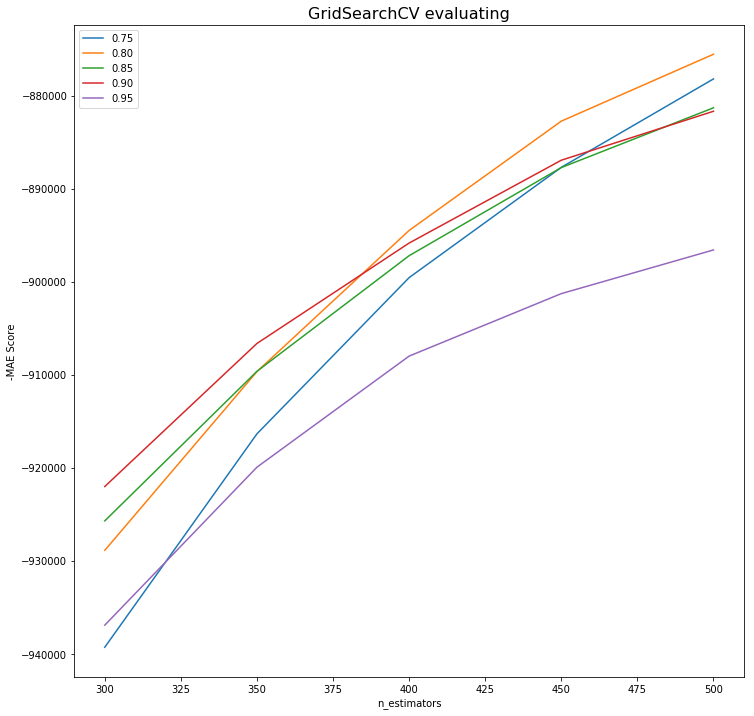

In [131]:
from matplotlib import pyplot as plt
plt.figure(figsize=(12, 12))
plt.title("GridSearchCV evaluating",
          fontsize=16)
plt.xlabel("n_estimators")
plt.ylabel("-MAE Score")
a=plt.gca()
a.plot(range(300,501,50), res[0:5], label='0.75')
a.plot(range(300,501,50), res[5:10], label='0.80')
a.plot(range(300,501,50), res[10:15], label='0.85')
a.plot(range(300,501,50), res[15:20], label='0.90')
a.plot(range(300,501,50), res[20:25], label='0.95')
plt.legend()
plt.show()


На графике видим, что при ещё больших количествах деревьев модель станет только лучше. Однако рост качества замедляется при увеличении learning_rate.
Отсюда делаем вывод, что его можно сделать поменьше, а деревьев побольше.

### Дальнейший подбор

In [133]:
mdlBo4 = sklearn.ensemble.GradientBoostingRegressor(min_samples_split=2)
gsBo4 = GridSearchCV(mdlBo4,
                  param_grid={'learning_rate' : numpy.arange(0.65,0.86,0.05), 'n_estimators' : range(550,800,50)},
                  scoring='neg_mean_absolute_error', cv=5, return_train_score=True, n_jobs=-1)
gsBo4.fit(X, y)
results = gsBo4.cv_results_

res=numpy.array(results['mean_test_score'])
res

array([-868007.70207084, -860546.59249657, -855385.51514075,
       -850648.24809862, -846641.02211251, -863688.33226684,
       -857552.17565201, -852370.40813025, -848643.00739136,
       -845176.56507407, -870479.16571655, -864574.07163363,
       -859868.40660803, -856694.90210498, -853398.3551048 ,
       -869999.72943985, -865340.6572962 , -862014.65852917,
       -859345.38490245, -857221.44696761, -876142.12696268,
       -872002.11961413, -868394.15768905, -864399.84648179,
       -860236.94242959])

In [134]:
results['params'][res.argmax()]

{'learning_rate': 0.7000000000000001, 'n_estimators': 750}

In [135]:
results['params']

[{'learning_rate': 0.65, 'n_estimators': 550},
 {'learning_rate': 0.65, 'n_estimators': 600},
 {'learning_rate': 0.65, 'n_estimators': 650},
 {'learning_rate': 0.65, 'n_estimators': 700},
 {'learning_rate': 0.65, 'n_estimators': 750},
 {'learning_rate': 0.7000000000000001, 'n_estimators': 550},
 {'learning_rate': 0.7000000000000001, 'n_estimators': 600},
 {'learning_rate': 0.7000000000000001, 'n_estimators': 650},
 {'learning_rate': 0.7000000000000001, 'n_estimators': 700},
 {'learning_rate': 0.7000000000000001, 'n_estimators': 750},
 {'learning_rate': 0.7500000000000001, 'n_estimators': 550},
 {'learning_rate': 0.7500000000000001, 'n_estimators': 600},
 {'learning_rate': 0.7500000000000001, 'n_estimators': 650},
 {'learning_rate': 0.7500000000000001, 'n_estimators': 700},
 {'learning_rate': 0.7500000000000001, 'n_estimators': 750},
 {'learning_rate': 0.8000000000000002, 'n_estimators': 550},
 {'learning_rate': 0.8000000000000002, 'n_estimators': 600},
 {'learning_rate': 0.800000000000

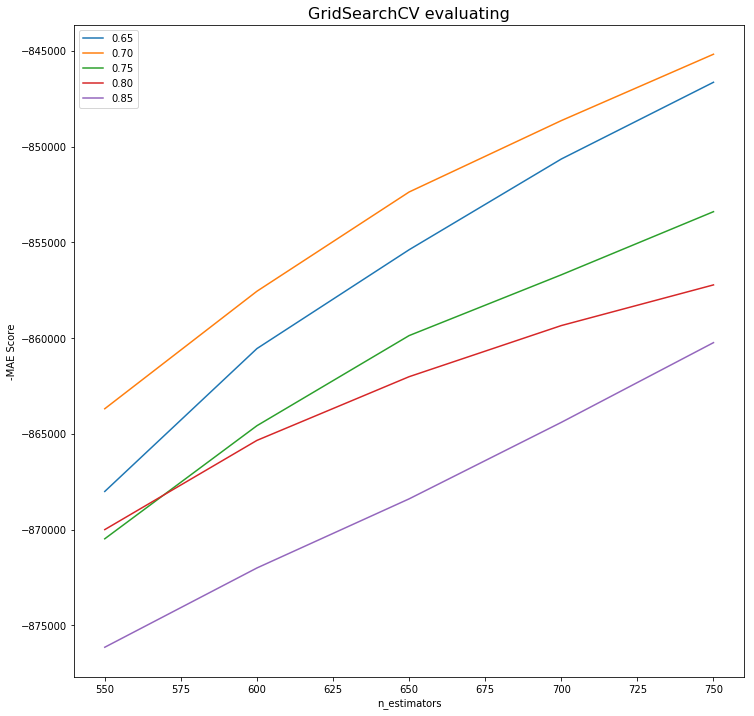

In [136]:
from matplotlib import pyplot as plt
plt.figure(figsize=(12, 12))
plt.title("GridSearchCV evaluating",
          fontsize=16)
plt.xlabel("n_estimators")
plt.ylabel("-MAE Score")
a=plt.gca()
a.plot(range(550,800,50), res[0:5], label='0.65')
a.plot(range(550,800,50), res[5:10], label='0.70')
a.plot(range(550,800,50), res[10:15], label='0.75')
a.plot(range(550,800,50), res[15:20], label='0.80')
a.plot(range(550,800,50), res[20:25], label='0.85')
plt.legend()
plt.show()

In [137]:
preds = gsBo4.predict(Xt)

test['price'] = preds

test[['id', 'price']].to_csv('sub_Bo4.csv', index=False)

In [138]:
mdlBo5 = sklearn.ensemble.GradientBoostingRegressor(min_samples_split=2)
gsBo5 = GridSearchCV(mdlBo5,
                  param_grid={'learning_rate' : numpy.arange(0.60,0.73,0.03), 'n_estimators' : range(800,1001,50)},
                  scoring='neg_mean_absolute_error', cv=5, return_train_score=True, n_jobs=-1)
gsBo5.fit(X, y)
results = gsBo5.cv_results_

res=numpy.array(results['mean_test_score'])
res

array([-835638.17676082, -832541.66712002, -829386.44497938,
       -827365.84804865, -826042.63511225, -838296.94788227,
       -835935.86698331, -833292.6640417 , -830302.50758231,
       -828820.63168036, -839117.39568785, -836832.90825358,
       -834478.39240527, -833552.43026478, -832360.90433584,
       -844786.46017473, -841521.90898934, -839582.97478253,
       -837746.20172581, -835766.58264374, -844727.19099304,
       -842907.20156933, -840387.64134382, -837786.45273036,
       -835545.0373446 ])

In [139]:
results['params'][res.argmax()]

{'learning_rate': 0.6, 'n_estimators': 1000}

In [140]:
results['params']

[{'learning_rate': 0.6, 'n_estimators': 800},
 {'learning_rate': 0.6, 'n_estimators': 850},
 {'learning_rate': 0.6, 'n_estimators': 900},
 {'learning_rate': 0.6, 'n_estimators': 950},
 {'learning_rate': 0.6, 'n_estimators': 1000},
 {'learning_rate': 0.63, 'n_estimators': 800},
 {'learning_rate': 0.63, 'n_estimators': 850},
 {'learning_rate': 0.63, 'n_estimators': 900},
 {'learning_rate': 0.63, 'n_estimators': 950},
 {'learning_rate': 0.63, 'n_estimators': 1000},
 {'learning_rate': 0.66, 'n_estimators': 800},
 {'learning_rate': 0.66, 'n_estimators': 850},
 {'learning_rate': 0.66, 'n_estimators': 900},
 {'learning_rate': 0.66, 'n_estimators': 950},
 {'learning_rate': 0.66, 'n_estimators': 1000},
 {'learning_rate': 0.6900000000000001, 'n_estimators': 800},
 {'learning_rate': 0.6900000000000001, 'n_estimators': 850},
 {'learning_rate': 0.6900000000000001, 'n_estimators': 900},
 {'learning_rate': 0.6900000000000001, 'n_estimators': 950},
 {'learning_rate': 0.6900000000000001, 'n_estimators'

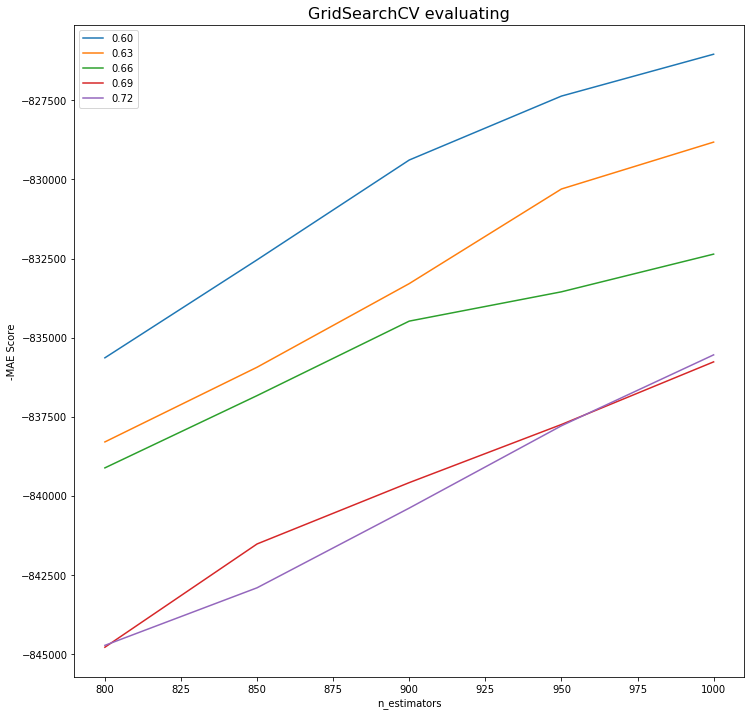

In [141]:
from matplotlib import pyplot as plt
plt.figure(figsize=(12, 12))
plt.title("GridSearchCV evaluating",
          fontsize=16)
plt.xlabel("n_estimators")
plt.ylabel("-MAE Score")
a=plt.gca()
x=range(800,1001,50)
a.plot(x, res[0:5], label='0.60')
a.plot(x, res[5:10], label='0.63')
a.plot(x, res[10:15], label='0.66')
a.plot(x, res[15:20], label='0.69')
a.plot(x, res[20:25], label='0.72')
plt.legend()
plt.show()

In [142]:
preds = gsBo5.predict(Xt)

test['price'] = preds

test[['id', 'price']].to_csv('sub_Bo5.csv', index=False)

In [143]:
mdlBo6 = sklearn.ensemble.GradientBoostingRegressor(min_samples_split=2)
gsBo6 = GridSearchCV(mdlBo6,
                  param_grid={'learning_rate' : numpy.arange(0.50,0.63,0.03), 'n_estimators' : range(900,1101,50)},
                  scoring='neg_mean_absolute_error', cv=5, return_train_score=True, n_jobs=-1)
gsBo6.fit(X, y)
results = gsBo6.cv_results_

res=numpy.array(results['mean_test_score'])
res

array([-833444.7985018 , -829311.97837135, -826579.14978621,
       -824393.34702204, -822120.3297511 , -829218.73376368,
       -826207.43575868, -824489.46029894, -822902.36769045,
       -820544.77315646, -832512.93672507, -829337.46289684,
       -827155.01260455, -825032.97195632, -823225.18750569,
       -832613.64538985, -829587.75826955, -828062.56308652,
       -825775.88275773, -824338.3548832 , -834594.44968963,
       -832260.80107533, -830801.02522148, -828244.80045337,
       -827574.04633765])

In [144]:
results['params'][res.argmax()]

{'learning_rate': 0.53, 'n_estimators': 1100}

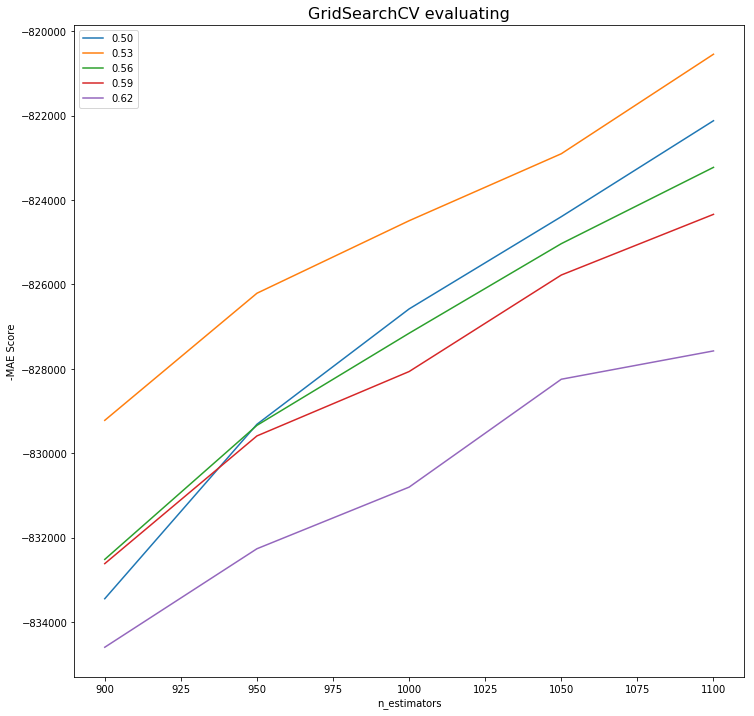

In [145]:
plt.figure(figsize=(12, 12))
plt.title("GridSearchCV evaluating",
          fontsize=16)
plt.xlabel("n_estimators")
plt.ylabel("-MAE Score")
a=plt.gca()
x=range(900,1101,50)
a.plot(x, res[0:5], label='0.50')
a.plot(x, res[5:10], label='0.53')
a.plot(x, res[10:15], label='0.56')
a.plot(x, res[15:20], label='0.59')
a.plot(x, res[20:25], label='0.62')
plt.legend()
plt.show()

Темпы улучшения замедлились, а запуск становится невыносимо долгим.

In [146]:
preds = gsBo6.predict(Xt)

test['price'] = preds

test[['id', 'price']].to_csv('sub_Bo6.csv', index=False)

##### Сейчас уже было бы самое время воспользоваться подстройкой,
например, в виде функции fmin из Hyperopt, но попытки её поставить, к сожалению, не увенчались успехом.
Пакет bayes_opt и вовсе написан только под линукс.
Поэтому крайний разик сделаем руками: посмотрим, будет ли переобучение по количеству деревьев.

In [149]:
mdlBo7 = sklearn.ensemble.GradientBoostingRegressor(min_samples_split=2)
gsBo7 = GridSearchCV(mdlBo7,
                  param_grid={'learning_rate' : numpy.arange(0.4,0.55,0.05), 'n_estimators' : range(1200,1501,100)},
                  scoring='neg_mean_absolute_error', cv=5, return_train_score=True, n_jobs=-1)
gsBo7.fit(X, y)
results = gsBo7.cv_results_

res=numpy.array(results['mean_test_score'])
res

array([-821356.8016598 , -817438.98197359, -813844.77262535,
       -810457.54990425, -816838.21244533, -813492.12942754,
       -810721.9216382 , -808419.45826457, -818627.90209706,
       -815356.0072279 , -813339.14188683, -811392.01487831,
       -818505.19387423, -816087.28079065, -814596.49601668,
       -813342.45521735])

In [150]:
results['params'][res.argmax()]

{'learning_rate': 0.45, 'n_estimators': 1500}

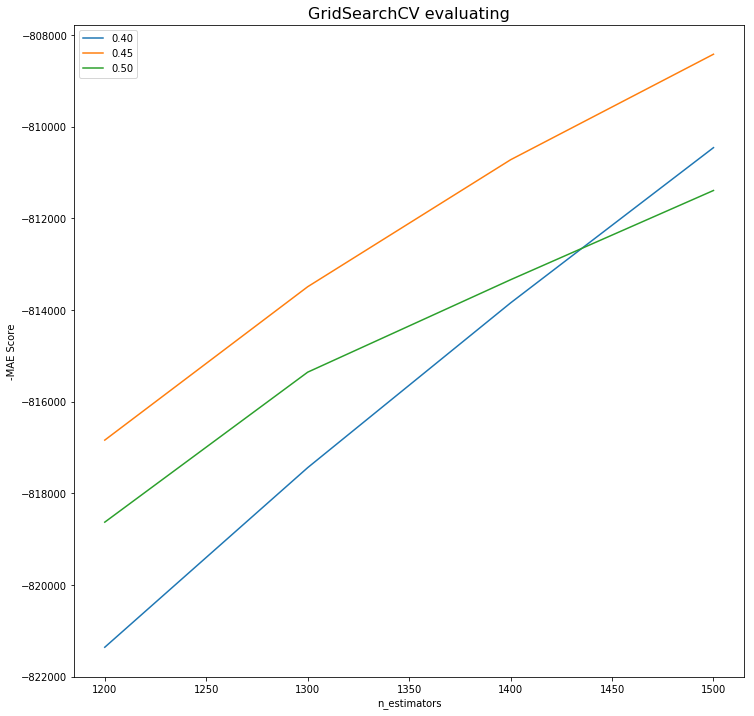

In [151]:
plt.figure(figsize=(12, 12))
plt.title("GridSearchCV evaluating",
          fontsize=16)
plt.xlabel("n_estimators")
plt.ylabel("-MAE Score")
a=plt.gca()
x=range(1200,1501,100)
a.plot(x, res[0:4], label='0.40')
a.plot(x, res[4:8], label='0.45')
a.plot(x, res[8:12], label='0.50')
plt.legend()
plt.show()

In [153]:
preds = gsBo7.predict(Xt)

test['price'] = preds

test[['id', 'price']].to_csv('sub_Bo7.csv', index=False)

Количество деревьев всё ещё можно увеличивать!

In [154]:
mdlBo8 = sklearn.ensemble.GradientBoostingRegressor(min_samples_split=2, learning_rate=0.35)
gsBo8 = GridSearchCV(mdlBo8,
                  param_grid={'n_estimators' : range(1600,2001,200)},
                  scoring='neg_mean_absolute_error', cv=5, return_train_score=True, n_jobs=-1)
gsBo8.fit(X, y)
results = gsBo8.cv_results_

res=numpy.array(results['mean_test_score'])
res

array([-810285.80645921, -805846.15002682, -801843.18994143])

In [155]:
results['params'][res.argmax()]

{'n_estimators': 2000}

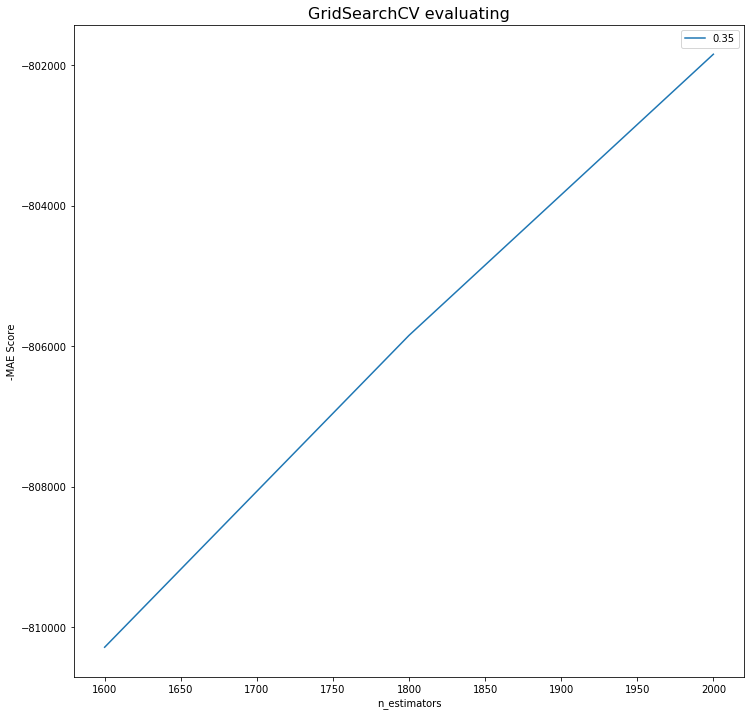

In [156]:
plt.figure(figsize=(12, 12))
plt.title("GridSearchCV evaluating",
          fontsize=16)
plt.xlabel("n_estimators")
plt.ylabel("-MAE Score")
a=plt.gca()
x=range(1600,2001,200)
a.plot(x, res[0:3], label='0.35')
plt.legend()
plt.show()

In [157]:
preds = gsBo8.predict(Xt)

test['price'] = preds

test[['id', 'price']].to_csv('sub_Bo8.csv', index=False)

Дальнейший рост по количеству деревьев малопродуктивен. Подберём learning_rate и остановимся на этом.

In [161]:
mdlBo9 = sklearn.ensemble.GradientBoostingRegressor(min_samples_split=2, n_estimators=2200)
gsBo9 = GridSearchCV(mdlBo9,
                  param_grid={'learning_rate' : numpy.arange(0.32,0.41,0.02)},
                  scoring='neg_mean_absolute_error', cv=5, return_train_score=True, n_jobs=-1)
gsBo9.fit(X, y)
results = gsBo9.cv_results_

res=numpy.array(results['mean_test_score'])
res

array([-798683.34682312, -799560.10764552, -801298.42887125,
       -797518.21420304, -800249.34828463])

In [162]:
results['params'][res.argmax()]

{'learning_rate': 0.38000000000000006}

In [163]:
preds = gsBo9.predict(Xt)

test['price'] = preds

test[['id', 'price']].to_csv('sub_Bo9.csv', index=False)

### Как же всё-таки учесть дату?

В задании сказано, что новые объявления имеют большую дату, чем в обучающей выборке. Но деревья, которыми мы пользовались до сих пор - хорошо интерполируют, но абсолютно никчемно экстраполируют. Поэтому есть опасения, что модель не будет хорошо работать на "будущих" данных. То есть она правильно определит и даст приемлимое соотношение между ценами объектов, но учесть инфляцию не выйдет.

In [227]:
train.head(3)

,id,date,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,...,kw6,kw7,kw8,kw9,kw10,kw11,kw12,kw13,price,mydate
0,0,2011-01-01,531,-1.0,12,35,1,1,25.0,-1.0,...,0,0,0,0,0,0,0,0,3721000,31
1,1,2011-01-01,385,2.0,15,46,1,2,15.0,1.0,...,0,0,0,0,0,0,0,0,7431000,31
2,2,2011-01-01,51,0.0,1,53,3,0,30.0,0.0,...,0,0,0,0,0,0,0,0,3081000,31


Поверим в линейность инфляции и запустим самую обыкновенную регрессию.

In [228]:
from sklearn.linear_model import LinearRegression
linmdl=LinearRegression()

xxx = numpy.array(train['mydate']).reshape((-1, 1))
yyy = numpy.array(train['price'])
yyy[0:5]

array([3721000, 7431000, 3081000, 3847000, 2323000], dtype=int64)

Получим параметры линейной модели

In [229]:
linmdl.fit(xxx, yyy)
print('intercept:', linmdl.intercept_)
print('slope:', linmdl.coef_)

intercept: 4427529.835904392
slope: [1934.43397749]


In [230]:
xlin = range(30,365,5)
coef=linmdl.coef_
inter=linmdl.intercept_
ylin = coef*x+inter

Рисуем зависимоть цены от даты и средню цену

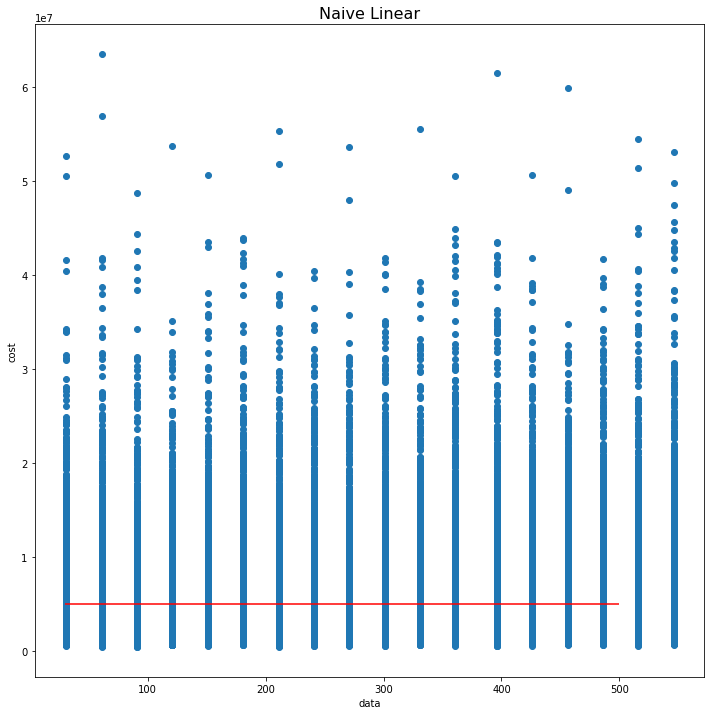

In [231]:
plt.figure(figsize=(12, 12))
plt.title("Naive Linear",
          fontsize=16)
plt.xlabel("data")
plt.ylabel("cost")
plt.scatter(xxx, yyy)
plt.hlines(y=numpy.mean(yyy), xmin=30, xmax=500, colors='r')
plt.show()

In [232]:
def inflation(date,inter,coef,mymean):
    return (coef*date+inter)/mymean

In [233]:
mymean=numpy.mean(yyy)
Xtt = test['mydate']
infl=Xtt.apply(lambda xtt: inflation(xtt,inter,coef,mymean))
infl[0:5]

0    [1.1003200653149883]
1    [1.1003200653149883]
2    [1.1003200653149883]
3    [1.1003200653149883]
4    [1.1003200653149883]
Name: mydate, dtype: object

На эти "коэффициенты инфляции" мы и будем умножать предсказание, построенное с помощью деревьев.

In [234]:
Xt = test[COLUMNS].values
preds1 =numpy.multiply(infl,gsBo9.predict(Xt))
preds1[0:5]

0     [4743143.534316049]
1    [10293941.726329874]
2     [3118120.874769084]
3     [7761343.915932036]
4    [1503343.6937012896]
Name: mydate, dtype: object

In [236]:
MAE(preds1,gsBo9.predict(Xt))

1058063.7647858725

Получилась средняя разница между предсказаниями с инфляцией и без неё. Попробуем сдать новый результат.

In [237]:
test['price'] = list(map(int,preds1))
test[['id', 'price']].to_csv('sub_Bo9+inf.csv', index=False)

test.head(3)

,id,date,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,...,kw6,kw7,kw8,kw9,kw10,kw11,kw12,kw13,mydate,price
0,100000,2012-06-01,427,-1.0,9,60,3,1,30.0,0.0,...,0,0,0,0,0,0,0,0,546,4743143
1,100001,2012-06-01,593,1.0,7,52,2,1,20.0,0.0,...,0,0,0,0,0,0,0,0,546,10293941
2,100002,2012-06-01,91,0.0,4,58,3,0,30.0,-1.0,...,0,0,0,0,0,0,0,0,546,3118120


После сдачи этой попытки результат чуть-чуть улучшился, но всё ещё колеблется на 9,2*10^5. При том, что средняя разница между попытками 10^6. Если раньше мы недооценивали значения, то возможно сейчас уже переоцениваем. Совершим ещё одну попытку, впрочем наивную, чтобы это проверить - возьмём половину от инфляции. 

In [238]:
Xt = test[COLUMNS].values
preds1 =numpy.multiply(1+(infl-1)/2,gsBo9.predict(Xt))
MAE(preds1,gsBo9.predict(Xt))

529031.8823929365

In [239]:
test['price'] = list(map(int,preds1))
test[['id', 'price']].to_csv('sub_Bo9+halfinf.csv', index=False)

test.head(3)

,id,date,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,...,kw6,kw7,kw8,kw9,kw10,kw11,kw12,kw13,mydate,price
0,100000,2012-06-01,427,-1.0,9,60,3,1,30.0,0.0,...,0,0,0,0,0,0,0,0,546,4526918
1,100001,2012-06-01,593,1.0,7,52,2,1,20.0,0.0,...,0,0,0,0,0,0,0,0,546,9824674
2,100002,2012-06-01,91,0.0,4,58,3,0,30.0,-1.0,...,0,0,0,0,0,0,0,0,546,2975975


Аххахах, какой нелепый путь к успеху! 

(перепрыгнул с 13-го места на 4-ое, вместо 9,2 на 10^5 стало 7,7 на 10^5)

Осталась одна попытка и нет времени придумывать что-то интеллектуальное.
Поэтому просто ради юмора:

In [242]:
Xt = test[COLUMNS].values
preds1 =numpy.multiply(1+(infl-infl[0]),gsBo9.predict(Xt))
MAE(preds1,gsBo9.predict(Xt))

558334.263217034

In [243]:
test['price'] = list(map(int,preds1))
test[['id', 'price']].to_csv('sub_Bo9+afterinf.csv', index=False)

test.head(3)

,id,date,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,...,kw6,kw7,kw8,kw9,kw10,kw11,kw12,kw13,mydate,price
0,100000,2012-06-01,427,-1.0,9,60,3,1,30.0,0.0,...,0,0,0,0,0,0,0,0,546,4310694
1,100001,2012-06-01,593,1.0,7,52,2,1,20.0,0.0,...,0,0,0,0,0,0,0,0,546,9355406
2,100002,2012-06-01,91,0.0,4,58,3,0,30.0,-1.0,...,0,0,0,0,0,0,0,0,546,2833830
